In [ ]:
import torch
torch.cuda.is_available()

True

Install libraries that we are going to use

In [ ]:
!pip install datasets transformers huggingface_hub evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


To use git in this model

In [ ]:
!apt-get install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


# Upload the kaggle dataset

In [ ]:
from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file.

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lhamiulutrkkan","key":"c8ef2a39d234e26adb4a05f916758d5d"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d emineyetm/fake-news-detection-datasets

Dataset URL: https://www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets
License(s): unknown
 95% 39.0M/41.0M [00:02<00:00, 23.5MB/s]
100% 41.0M/41.0M [00:02<00:00, 14.8MB/s]


In [ ]:
import zipfile
import os

# Unzip the dataset
with zipfile.ZipFile("fake-news-detection-datasets.zip", "r") as zip_ref:
    zip_ref.extractall("fake-news-detection-datasets")

# Verify the files
print(os.listdir("fake-news-detection-datasets"))

['News _dataset']


# Define the function to remove stopwords

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Define stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(example):
    example['text'] = ' '.join([word for word in example['text'].split() if word.lower() not in stop_words])
    return example

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Merge 3 different datasets to measure generalablity of the model best and remove the stopwords from them

In [ ]:
import pandas as pd
from datasets import load_dataset
from datasets import Dataset
from sklearn.model_selection import train_test_split

# Example: Load a CSV file
fakes = pd.read_csv("/content/fake-news-detection-datasets/News _dataset/Fake.csv")
trues = pd.read_csv("/content/fake-news-detection-datasets/News _dataset/True.csv")

# Add a label part both
fakes["label"] = 0
trues["label"] = 1

# merge these sets
merged_df = pd.concat([fakes, trues], ignore_index=True)
# remove subject and date columns
merged_df = merged_df.drop(["subject", "date"], axis=1)
# merge title and text columns with :
merged_df["text"] = merged_df["title"] + " : " + merged_df["text"]
# remove title column
merged_df = merged_df.drop(["title"], axis=1)
# shuffle data
merged_df = merged_df.sample(frac=1, random_state=42).reset_index(drop=True)
pol_dataset = Dataset.from_pandas(merged_df)
pol_dataset = pol_dataset.select(range(10000))
print(pol_dataset.column_names)  # Check column names in the split

# Another dataset----------------------------------------------------------------------------------------------------
ds = load_dataset("noahgift/fake-news")
print(ds.column_names)  # Check column names in the split
ds1 = ds["train"]
ds1 = ds1.select_columns(["text", "label"])
ds1 = ds1.select(range(2000))
# Define a mapping from string labels to integers
label_mapping2 = {"Real": 1, "Fake": 0}
ds1 = ds1.map(lambda example: {"label": label_mapping2[example["label"]]})
print(ds1.column_names)  # Check column names in the split

# Last dataset----------------------------------------------------------------------------------------------------
dataset = load_dataset("Cartinoe5930/Politifact_fake_news")
dataset1 = dataset["train"]
# cahgen the column anme news to text
dataset1 = dataset1.rename_column("news", "text")
dataset1 = dataset1.select_columns(["text", "label"])
dataset1 = dataset1.select(range(10000))
print(dataset1.column_names)  # Check column names in the split



# merge pol_dataset, dataset1, and ds1
merged_df = pd.concat([pol_dataset.to_pandas(), dataset1.to_pandas(), ds1.to_pandas()], ignore_index=True)

# shuffle
merged_df = merged_df.sample(frac=1, random_state=42).reset_index(drop=True)

#convert to dataset
merged_df = Dataset.from_pandas(merged_df)
print(merged_df.column_names)  # Check column names in the split
print(merged_df[0])
merged_df = merged_df.map(remove_stopwords)
print(merged_df[0])


#split to train and test
dataset_split = merged_df.train_test_split(test_size=0.2, seed=42)
train_df = dataset_split["train"]
test_df = dataset_split["test"]
#check
print(train_df.column_names)  # Check column names in the split
print(test_df.column_names)  # Check column names in the spli
print(train_df.shape)
print(test_df.shape)


['text', 'label']


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/20.0 [00:00<?, ?B/s]

news_articles.csv:   0%|          | 0.00/11.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2096 [00:00<?, ? examples/s]

{'train': ['author', 'published', 'title', 'text', 'language', 'site_url', 'main_img_url', 'type', 'label', 'title_without_stopwords', 'text_without_stopwords', 'hasImage']}


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text', 'label']


README.md:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/92.3M [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/22.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/17090 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4228 [00:00<?, ? examples/s]

['text', 'label']
['text', 'label']
{'text': 'In 2017, Joe Biden paid $3,742,974 in federal income taxes and Kamala Harris paid $516,469 while Donald Trump paid $750 In 2017, President Donald Trump paid only $750 in federal income taxes, according to the New York Times, which reported on Sept. 27 that it had obtained the president’s tax information covering more than two decades. The news drew the disdain of some of Trump’s detractors even as the president, who has fought to keep his tax returns private, denied the story. "Little by little, we will see exactly why he is trying so hard to hide his tax returns!!" read one Facebook post sharing a screenshot of a tweet comparing Trump’s tax returns to those of Democratic presidential candidates, including Democratic presidential nominee, Joe Biden, and his running mate, Kamala Harris. "Federal income taxes paid in 2017 (jointly with spouse): Joe Biden - $3,742,974," the tweet says. "Kamala Harris - $516,469, Bernie Sanders - $343,882, Eliz

Map:   0%|          | 0/22000 [00:00<?, ? examples/s]

{'text': '2017, Joe Biden paid $3,742,974 federal income taxes Kamala Harris paid $516,469 Donald Trump paid $750 2017, President Donald Trump paid $750 federal income taxes, according New York Times, reported Sept. 27 obtained president’s tax information covering two decades. news drew disdain Trump’s detractors even president, fought keep tax returns private, denied story. "Little little, see exactly trying hard hide tax returns!!" read one Facebook post sharing screenshot tweet comparing Trump’s tax returns Democratic presidential candidates, including Democratic presidential nominee, Joe Biden, running mate, Kamala Harris. "Federal income taxes paid 2017 (jointly spouse): Joe Biden - $3,742,974," tweet says. "Kamala Harris - $516,469, Bernie Sanders - $343,882, Elizabeth Warren - $268,484, Donald Trump - $750." post flagged part Facebook’s efforts combat false news misinformation News Feed. (Read partnership Facebook.) reached Trump Biden campaigns, well office Sen. Bernie Sanders,

# Load the tokenizer



In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# Tokenization

In [ ]:
def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True)

# Now you can map with batched=True
tokenized_train = train_df.map(preprocess_function, batched=True)
tokenized_test = test_df.map(preprocess_function, batched=True)

# Show the shape of the datas
print(tokenized_train.shape)
print(tokenized_test.shape)

#Show the first 5 elements of the datasets
print(tokenized_train[:5])
print(tokenized_test[:5])

Map:   0%|          | 0/17600 [00:00<?, ? examples/s]

Map:   0%|          | 0/4400 [00:00<?, ? examples/s]

(17600, 4)
(4400, 4)
{'text': ['SIX PROMINENT DEMOCRATS CALLED VIOLENCE Americans Don’t Agree Politics [VIDEO] : Today act terror GOP Congressional baseball team Bernie Sanders supporter ugly hateful anyone could imagine. one surprised violent act, given many leaders Democrat Party calling violence anyone disagrees radical progressive agenda, starting former president community organizer, Barack Obama. Below, list 6 prominent Democrats called violence Americans disagree them. course, actions largely ignored deemed acceptable behavior allies mainstream media #1. President Obama grassroots Organizing Action, message supporters, said voters turned back time respond fighting harder ever before. Barack Obama would suggest Democrats fight harder ever come surprise anyone paying attention. former president community organizer stranger calling violence anyone agree him.In 2008, made comment rubbing opponents Chicago way suggested [Republicans] bring knife fight, [Democrats] bring gun. Obama al

**Use data_collator to speed up training**

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

\# Upload the distilBERT model to fine-tune

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Evaluation Metrices**

In [ ]:
import numpy as np
import evaluate
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    accuracy = accuracy_score(labels, predictions)
    return {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }



In [ ]:
from huggingface_hub import notebook_login
notebook_login()

# COMMAND 1

# **Train the distilBERT model with created dataset and evaluate it. This is our baseline.**

In [ ]:
from transformers import TrainingArguments, Trainer

repo_name = "fake-news-model-22000-samples"

dataset_split = tokenized_train.train_test_split(test_size=0.2, seed=42)

# Extract training and validation datasets
train_dataset = dataset_split["train"]
eval_dataset = dataset_split["test"]

training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=10,
   weight_decay=0.01,
   save_strategy="epoch",
   eval_strategy="epoch",  # Evaluate at the end of each epoch
   logging_dir=f"{repo_name}/logs",  # Directory for logs
   logging_strategy="epoch",  # Log metrics at the end of each epoch
   push_to_hub=True,
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=train_dataset,
   eval_dataset=eval_dataset,
   processing_class=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)


In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.312000,0.266006,0.862784,0.828784,0.824982,0.832621
2,0.239400,0.251674,0.873295,0.847989,0.813072,0.886040
3,0.187100,0.301199,0.863068,0.839654,0.787765,0.898860
4,0.130600,0.461953,0.878125,0.846731,0.849462,0.844017
5,0.082500,0.689681,0.870170,0.840042,0.825877,0.854701
6,0.044600,0.779838,0.869602,0.841011,0.818611,0.864672
7,0.026700,0.838632,0.869602,0.831436,0.858226,0.806268
8,0.015600,0.976449,0.869602,0.835896,0.839196,0.832621
9,0.013400,1.016709,0.870455,0.836910,0.840517,0.833333
10,0.006300,1.033144,0.872159,0.838594,0.844653,0.832621


TrainOutput(global_step=8800, training_loss=0.10582297482273795, metrics={'train_runtime': 1653.6956, 'train_samples_per_second': 85.143, 'train_steps_per_second': 5.321, 'total_flos': 1.86514097307648e+16, 'train_loss': 0.10582297482273795, 'epoch': 10.0})

# Push to hub to use again.

In [ ]:
trainer.push_to_hub()

events.out.tfevents.1735040137.4e57bcf02596.557.0:   0%|          | 0.00/12.1k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ilhamiuturkkan/fake-news-model-22000-samples/commit/0882a7c0536d45d54aff9429af40ccb3f974f030', commit_message='End of training', commit_description='', oid='0882a7c0536d45d54aff9429af40ccb3f974f030', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ilhamiuturkkan/fake-news-model-22000-samples', endpoint='https://huggingface.co', repo_type='model', repo_id='ilhamiuturkkan/fake-news-model-22000-samples'), pr_revision=None, pr_num=None)

# Load the trained model


In [ ]:
from transformers import pipeline
fake_news_model = pipeline(model="ilhamiuturkkan/fake-news-model-22000-samples", device=0)

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0


# Since distilBERT has max 512 token capacity. Tokenize the input with respect to it.

In [ ]:
def truncate_texts_to_max_length(texts, tokenizer, max_length=512):
    return [
        tokenizer.decode(
            tokenizer(
                text,
                max_length=max_length,
                truncation=True,  # Ensure truncation
            )["input_ids"],
            skip_special_tokens=True,
        )
        for text in texts
    ]

# Test the trained distilBERT model

In [ ]:
from datasets import load_dataset

# Truncate texts to the model's maximum token length
test_texts = truncate_texts_to_max_length(tokenized_test["text"], tokenizer)
test_labels = tokenized_test["label"]

outputs = fake_news_model(test_texts)

# Define a mapping from string labels to integers
label_mapping = {"LABEL_0": 0, "LABEL_1": 1}

# Convert predictions to integers by accessing the "label" key
predictions = [label_mapping[output["label"]] for output in outputs]
ground_truths = test_labels
# Compute accuracy
accuracy = accuracy_score(ground_truths, predictions)
print(f"Accuracy with trained model: {accuracy}")


Accuracy with trained model: 0.8672727272727273


# COMMAND 2

# Now, work for LSTM

In [ ]:
train_texts = tokenizer(train_dataset["text"], return_tensors="pt", padding='max_length', truncation=True, max_length=256)
train_labels = train_dataset["label"]
val_texts = tokenizer(eval_dataset["text"], return_tensors="pt", padding='max_length', truncation=True, max_length=256)
val_labels = eval_dataset["label"]
test_texts = tokenizer(tokenized_test["text"], return_tensors="pt", padding='max_length', truncation=True, max_length=256)
test_labels = tokenized_test["label"]

**First get the embeddings of the train set texts**

In [ ]:
from torch.utils.data import DataLoader, TensorDataset, random_split
labels_tensor = torch.tensor(train_labels)
dataset = TensorDataset(train_texts.input_ids, train_texts.attention_mask, labels_tensor)
loader = DataLoader(dataset, batch_size=32)

In [ ]:
from transformers import DistilBertTokenizer, DistilBertModel
model = DistilBertModel.from_pretrained('distilbert-base-uncased', num_labels=2)

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

embeddings = []
for batch in loader:
    # Move inputs to the same device as the model
    batch_input_ids, batch_attention_mask = batch[0].to(device), batch[1].to(device)
    with torch.no_grad():
        # Get the embeddings from the model
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        batch_embeddings = outputs.last_hidden_state.cpu().numpy()  # Move embeddings to CPU for storage
        embeddings.append(batch_embeddings)


In [ ]:
train_embeddings = np.concatenate(embeddings, axis=0)
#Random embedding to verify
print(train_embeddings[12])

[[-0.00841036 -0.1567997  -0.03365439 ... -0.10199925  0.40046704
   0.03318043]
 [ 0.15406263  0.03604116  0.53279257 ...  0.15005158  0.6114519
  -0.53815347]
 [-0.8371948  -0.00462489  0.21992446 ... -0.17137337  0.5312654
  -0.4249877 ]
 ...
 [-0.21352682 -0.22755608  0.9084742  ...  0.19863619  0.75787896
   0.05590253]
 [-0.96946055 -1.0987988   0.43524885 ...  0.5621781   0.6151288
  -0.619442  ]
 [ 0.01374284  0.11419246  0.23427595 ...  0.19650522  0.07696024
  -1.2574021 ]]


**Now, get the embeddings of evaluation set**

In [ ]:
labels_tensor = torch.tensor(val_labels)
dataset = TensorDataset(val_texts.input_ids, val_texts.attention_mask, labels_tensor)
loader = DataLoader(dataset, batch_size=32)
model = model.to(device=0)

embeddings = []
for batch in loader:
    # Move inputs to the same device as the model
    batch_input_ids, batch_attention_mask = batch[0].to(device), batch[1].to(device)
    with torch.no_grad():
        # Get the embeddings from the model
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        batch_embeddings = outputs.last_hidden_state.cpu().numpy()  # Move embeddings to CPU for storage
        embeddings.append(batch_embeddings)

In [ ]:
val_embeddings = np.concatenate(embeddings, axis=0)

# Now, define the LSTM Biderctional Model and train it with obtained embeddings.

In [ ]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from transformers import Trainer, AutoTokenizer, AdamW, TrainingArguments

dropout_rate = 0.2
l2_strength=0.005
print((train_embeddings.shape[1], train_embeddings.shape[2]))
bidirectional_model = tf.keras.Sequential([
    tf.keras.Input(shape=(train_embeddings.shape[1], train_embeddings.shape[2])),
    #tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(l2_strength)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, dropout=dropout_rate, recurrent_dropout=dropout_rate, kernel_regularizer=l2(l2_strength))),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(l2_strength)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(2, activation='softmax', kernel_regularizer=l2(l2_strength))])


(256, 768)


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

bidirectional_model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for finer updates
    loss=CategoricalCrossentropy(label_smoothing=0.1),  # Label smoothing for better generalization
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.F1Score(name='f1_score')
    ]
)


In [ ]:
from tensorflow.keras.utils import to_categorical

train_y_one_hot = to_categorical(train_labels, num_classes=2)
val_y_one_hot = to_categorical(val_labels, num_classes=2)

In [ ]:
#Check the shapes.
print(train_embeddings.shape)
print(val_embeddings.shape)
print(np.array(train_y_one_hot).shape)
print(np.array(val_y_one_hot).shape)

(14080, 256, 768)
(3520, 256, 768)
(14080, 2)
(3520, 2)


Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 82s 349ms/step - accuracy: 0.6822 - f1_score: 0.6394 - loss: 6.2672 - precision: 0.6822 - recall: 0.6822 - val_accuracy: 0.8125 - val_f1_score: 0.8051 - val_loss: 3.7469 - val_precision: 0.8125 - val_recall: 0.8125
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 72s 327ms/step - accuracy: 0.8158 - f1_score: 0.8068 - loss: 3.2699 - precision: 0.8158 - recall: 0.8158 - val_accuracy: 0.8259 - val_f1_score: 0.8196 - val_loss: 2.1366 - val_precision: 0.8259 - val_recall: 0.8259
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 73s 332ms/step - accuracy: 0.8342 - f1_score: 0.8258 - loss: 1.9184 - precision: 0.8342 - recall: 0.8342 - val_accuracy: 0.8355 - val_f1_score: 0.8291 - val_loss: 1.3928 - val_precision: 0.8355 - val_recall: 0.8355
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 73s 331ms/step - accuracy: 0.8378 - f1_score: 0.8297 - loss: 1.2959 - precision: 0.8378 - recall: 0.8378 - val_accuracy: 0.8315 - val_f1_score: 0.8262 - val_loss: 1.0459 - val_precision: 0.8315 -

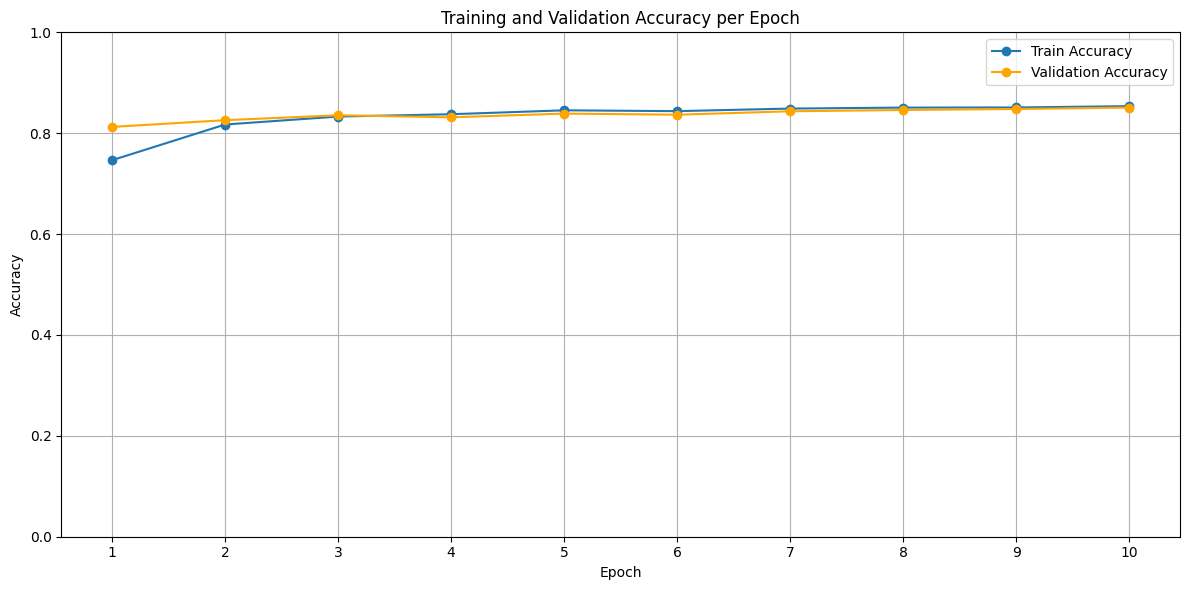

In [ ]:
import matplotlib.pyplot as plt

batch_size = 64
num_epochs = 10

train_history = bidirectional_model.fit(train_embeddings,
                                          np.array(train_y_one_hot),
                                          batch_size=batch_size,
                                          epochs=num_epochs,
                                          validation_data=(val_embeddings, np.array(val_y_one_hot)))

# Extract metrics
train_accuracy = train_history.history['accuracy']
val_accuracy = train_history.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

# Plotting
plt.figure(figsize=(12, 6))

# Train Accuracy
plt.plot(epochs, train_accuracy, marker='o', linestyle='-', label="Train Accuracy")

# Validation Accuracy
plt.plot(epochs, val_accuracy, marker='o', linestyle='-', label="Validation Accuracy", color="orange")

# Title and Labels
plt.title("Training and Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(epochs)
plt.ylim(0, 1)
plt.grid(True)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
labels_tensor = torch.tensor(test_labels)
dataset = TensorDataset(test_texts.input_ids, test_texts.attention_mask, labels_tensor)
loader = DataLoader(dataset, batch_size=32)

model = model.to(device=0)

embeddings = []
for batch in loader:
    # Move inputs to the same device as the model
    batch_input_ids, batch_attention_mask = batch[0].to(device), batch[1].to(device)
    with torch.no_grad():
        # Get the embeddings from the model
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        batch_embeddings = outputs.last_hidden_state.cpu().numpy()  # Move embeddings to CPU for storage
        embeddings.append(batch_embeddings)
test_embeddings = np.concatenate(embeddings, axis=0)

test_y_one_hot = to_categorical(test_labels, num_classes=2)

test_history = bidirectional_model.evaluate(test_embeddings, np.array(test_y_one_hot))

138/138 ━━━━━━━━━━━━━━━━━━━━ 18s 124ms/step - accuracy: 0.8425 - f1_score: 0.8364 - loss: 0.5939 - precision: 0.8425 - recall: 0.8425


In [ ]:
bidirectional_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 256, 256)            │         918,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 256)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,805,320 (10.70 MB)

 Trainable params: 935,106 (3.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,870,214 (7.13 MB)